In [1]:
import matplotlib.pyplot as plt
import torch
cuda = torch.device("cuda:2")

from fitting import create_ensemble, load_data, create_datasets
import torch
labels = ["x (mm)", r"$p_x$ (mrad)","y (mm)",r"$p_y$ (mrad)","z (mm)",r"$p_z$ (mrad)"]

tkwargs = {"dtype": torch.float, "device":cuda}
base_dir = "/global/cfs/cdirs/m669/rroussel/phase_space_reconstruction/"
save_dir = base_dir + "mse_scale_1_l_1e12"
quad_strengths, image_data, bins, xx = load_data(base_dir, tkwargs)
xx = xx.cpu()
train_dset = torch.load(save_dir + "/train.dset")
test_dset = torch.load(save_dir + "/test.dset")

bin_width = bins[1] - bins[0]
bandwidth = bin_width / 2
ensemble = create_ensemble(bins, bandwidth)

from torchensemble.utils import io
io.load(ensemble, save_dir)

n_particles = 1000000
for ele in ensemble:
    ele.beam.set_base_beam(
        ele.beam.base_dist,
        n_particles,
        p0c=torch.tensor(63.0e6)
    )

ensemble = ensemble.to(device=cuda);

frac = 1.0
s = slice(0,4)

# get beam reconstruction from slit scan measurement
import numpy as np
meas_y = torch.tensor(np.load(base_dir + "y_recon.npy"))
meas_yp = torch.tensor(np.load(base_dir + "yp_recon.npy"))
slit_data = torch.stack([meas_y, meas_yp]).T
slit_core = slit_data

covs = []
for i in range(4):
    initial_beam = ensemble[i].beam().data
    re_core = initial_beam

    covs += [torch.cov(re_core.T)]

covs = torch.stack(covs)
covs.shape



/global/homes/r/rroussel/.conda/envs/phase_space_reconstruction/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/global/homes/r/rroussel/.conda/envs/phase_space_reconstruction/lib/python3.10/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([4, 6, 6])

In [7]:
xemittances = torch.det(covs[1:,:2,:2]).sqrt()*1e6 * 63/0.511
yemittances = torch.det(covs[1:,2:4,2:4]).sqrt()*1e6 * 63/0.511
print(f"enx {xemittances.mean()} +/- {xemittances.std()}")
print(f"eny {yemittances.mean()} +/- {yemittances.std()}")

print(torch.cov(slit_data.T).det().sqrt()*1e6 * 63/0.511)


enx 4.23349666595459 +/- 0.01911298930644989
eny 3.418896198272705 +/- 0.01687755063176155
tensor(3.9027, dtype=torch.float64)


In [3]:
xemittances

tensor([4.1950, 4.2163, 4.2302, 4.2541], device='cuda:2',
       grad_fn=<DivBackward0>)

In [4]:
yemittances

tensor([3.2906, 3.3994, 3.4296, 3.4276], device='cuda:2',
       grad_fn=<DivBackward0>)

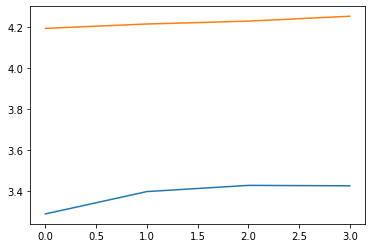

In [5]:
plt.plot(yemittances.cpu().detach())
plt.plot(xemittances.cpu().detach())

In [6]:
reconstruction_data = initial_beam.data




gt_cov = torch.cov(gt_core.T)
re_cov = torch.cov(re_core.T)

print(torch.det(gt_cov[:2,:2]).sqrt())
print(torch.det(re_cov[:2,:2]).sqrt())

print(torch.det(gt_cov[2:4,2:4]).sqrt())
print(torch.det(re_cov[2:4,2:4]).sqrt())

NameError: name 'gt_core' is not defined

In [ ]:
plt.plot(*gt_core.T[:2,::100].cpu().detach(), '.')
plt.plot(*re_core.T[:2,::100].cpu().detach(), '.')

plt.figure()
plt.plot(*gt_core.T[2:4,::100].cpu().detach(), '.')
plt.plot(*re_core.T[2:4,::100].cpu().detach(), '.')